<a href="https://colab.research.google.com/github/farayal/memoria_turbofan/blob/master/turbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

### Train Set preprocesamiento


In [0]:
#Creación dataframe train set para preprocesamiento 

df = pd.read_csv('train_FD001.txt', sep = ' ', header = None)
df = df.drop(columns=[26, 27])
df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)

In [0]:
#Agregada variable RUL a df y normalización de columnas (salvo RUL)
RUL_temp=np.zeros(0)
for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
df['RUL'] = RUL_temp
df['RUL'] = df['RUL'].astype(int)
scaler = MinMaxScaler(feature_range=(-1,1))
df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

In [4]:
#contenido dataframe df
df.iloc[0:30][:].head()

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21,RUL
0,1,-1.000000,-0.080460,-0.666667,-1.0,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.600784,-0.272028,-0.333333,0.426357,0.449323,191
1,1,-0.994460,0.218391,-0.500000,-1.0,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.674373,-0.177376,-0.333333,0.333333,0.462027,190
2,1,-0.988920,-0.494253,0.500000,-1.0,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.656414,-0.285110,-0.666667,0.255814,0.242751,189
3,1,-0.983380,0.080460,0.000000,-1.0,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.650222,-0.666795,-0.333333,0.147287,0.324772,188
4,1,-0.977839,-0.218391,-0.333333,-1.0,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.650532,-0.195845,-0.166667,0.178295,0.409003,187


In [0]:
# Creación de features maps

features_maps=np.empty((30,14,1))
df_ys = np.zeros((1,1))
for i in range(1,df['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp1 = df[df['n_engine'] == i]
  df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_features = df_temp2.drop(['RUL'],axis = 1)
  df_y = df_temp2['RUL'].to_numpy()
  df_ys = np.append(df_ys,df_y[29:])
  for j in range(len(df_y)-29):
    feature_map = df_features[j:j+30][:]
    features_maps = np.dstack((features_maps, feature_map))
features_maps=np.delete(features_maps, 0, 2)
df_ys = np.delete(df_ys, 0, 0)

In [6]:
#Dimensiones feature maps y features maps apilados
print(features_maps.shape)
print(feature_map.shape)

(30, 14, 17731)
(30, 14)


In [7]:
# cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
print(df_ys.shape)
features_maps = np.moveaxis(features_maps, 2, 0)
print(features_maps.shape)

(17731,)
(17731, 30, 14)


In [8]:
# Expansion a 2 dimensiones para vector con Yverdaderos (RUL conjunto de entrenamiento) y 4 para features maps
df_ys = np.expand_dims(df_ys,axis=1)
features_maps= np.expand_dims(features_maps,3)
print(df_ys.shape)
print(features_maps.shape)

(17731, 1)
(17731, 30, 14, 1)


In [9]:
# Se barajan pares  (feature map, Yverdadero(RUL)) en forma aleatoria para evitar sesgo al comenzar
# el entreno de las ANN

from sklearn.utils import shuffle

features_maps, df_ys = shuffle(features_maps, df_ys, random_state=5)

# Todos los rul > a 125 se setean en 125 segun papers

for i in range(len(df_ys)):
  if df_ys[i] >= 125:
    df_ys[i] = 125
  else:
    df_ys[i] = df_ys[i]

print(df_ys)

# 

ys_train = df_ys[:int(len(df_ys)*0.9)]
ys_valid = df_ys[int(len(df_ys)*0.9):]

features_maps_train = features_maps[:int(len(df_ys)*0.9)]
features_maps_valid = features_maps[int(len(df_ys)*0.9):]

[[125.]
 [ 96.]
 [106.]
 ...
 [125.]
 [ 41.]
 [125.]]


## Test set

In [0]:
df_t = pd.read_csv('test_FD001.txt', sep = ' ', header = None)
df_t = df_t.drop(columns=[26, 27])
df_t.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df_t = df_t.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
df_t[df_t.columns[1:19]]= scaler.transform(df_t[df_t.columns[1:19]])

In [11]:
ruls_test= []
rul_file = open("RUL_FD001.txt", "r")
for rul_line in rul_file:
  ruls_test.append(int(rul_line.rstrip(' \n')))
print(ruls_test)


[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]


In [0]:
features_maps_test=np.empty((30,14,1))
for i in range(1,df_t['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp = df_t[df_t['n_engine'] == i].drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_large = df_temp['sens_8'].count()
  feature_map = df_temp[df_large-30:][:]
  features_maps_test = np.dstack((features_maps_test, feature_map))
features_maps_test=np.delete(features_maps_test, 0, 2)

In [13]:
print(features_maps_test.shape)
print(feature_map.shape)

(30, 14, 100)
(30, 14)


In [14]:
features_maps_test = np.moveaxis(features_maps_test, 2, 0)
print(features_maps_test.shape)

(100, 30, 14)


In [15]:
features_maps_test= np.expand_dims(features_maps_test,3)
print(features_maps_test.shape)

(100, 30, 14, 1)


In [16]:
list1 = np.array(ruls_test)
list2 = np.array(features_maps_test)
idx   = np.argsort(list1)

list1 = np.array(list1)[idx]
list2 = np.array(list2)[idx]

for i in range(len(list1)):
  if list1[i] >= 125:
    list1[i] = 125
  else:
    list1[i] = list1[i]

print(list1)

[  7   8   8   8   9  10  10  11  14  15  16  18  19  20  20  20  21  21
  21  26  28  28  28  28  29  34  37  38  47  48  50  50  50  54  55  57
  58  59  59  63  66  69  72  77  79  82  82  83  84  85  87  89  90  90
  91  91  92  93  94  95  95  96  97  97  97  98 100 103 106 107 107 109
 111 111 112 113 113 114 114 114 115 115 116 117 118 118 119 121 124 125
 125 125 125 125 125 125 125 125 125 125]


# CNN 

Propuesta de Li, Ding, Sun

![Imagen](https://github.com/farayal/memoria_turbofan/blob/master/cnn_regression.png?raw=true)

In [17]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers

import keras.backend as K
K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [0]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    #Layer 1
    # Zero-Padding: Para originar un output (20,14) en la siguiente capa
    #X = ZeroPadding2D((5, 0))(X_input)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3
    #X = ZeroPadding2D((5, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5
    #X = ZeroPadding2D((1, 0))(X)
    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(100, activation='tanh', name='fully-connected')(X)
    #X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [19]:
cnnturbofan = cnnturbofan((features_maps.shape[1],features_maps.shape[2],features_maps.shape[3]))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

cnnturbofan.compile(optimizer = "Adam", loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [21]:
history = cnnturbofan.fit(x = features_maps_train, y = ys_train ,batch_size=1024, epochs = 250 ,validation_data=(features_maps_valid,ys_valid))




Train on 15957 samples, validate on 1774 samples
Epoch 1/250





15957/15957 [==============================] - 3s 205us/step - loss: 7197.8052 - root_mean_squared_error: 84.7338 - val_loss: 6412.5494 - val_root_mean_squared_error: 80.0728
Epoch 2/250
15957/15957 [==============================] - 1s 50us/step - loss: 6247.6843 - root_mean_squared_error: 79.0334 - val_loss: 6063.1587 - val_root_mean_squared_error: 77.8601
Epoch 3/250
15957/15957 [==============================] - 1s 50us/step - loss: 5932.1684 - root_mean_squared_error: 77.0109 - val_loss: 5807.4791 - val_root_mean_squared_error: 76.2007
Epoch 4/250
15957/15957 [==============================] - 1s 50us/step - loss: 5696.8736 - root_mean_squared_error: 75.4667 - val_loss: 5588.9966 - val_root_mean_squared_error: 74.7536
Epoch 5/250
15957/15957 [==============================] - 1s 50us/step - loss: 5481.7138 - root_mean_squared_error: 74.0293 - val_loss: 5382.2646 - val_root_mean_squared_error: 73.3581
Epoch 6/250


In [22]:
  cnnturbofan.summary()

Model: "cnnturbofan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 14, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 30, 14, 10)        110       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 14, 10)        

In [0]:
hola = cnnturbofan.predict(features_maps)

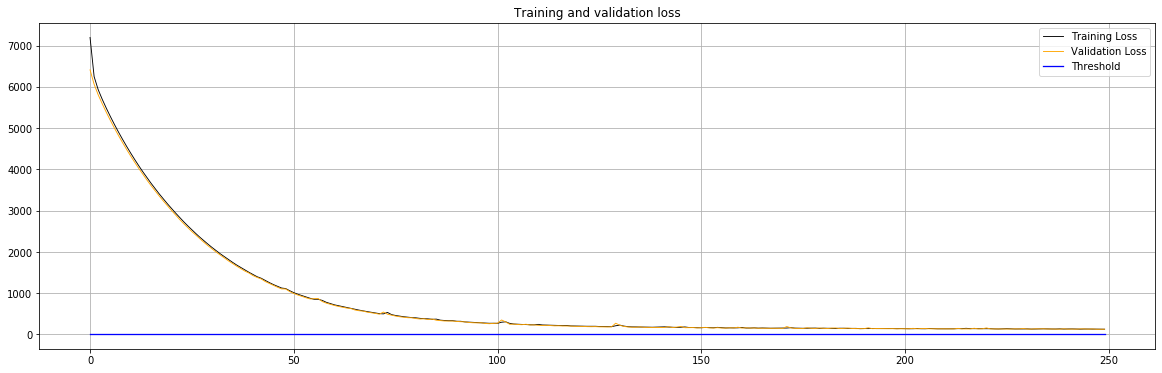

In [24]:
#acc = history.history['mean_absolute_error']
#val_acc = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

##plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(20,6))
plt.grid(True) 
plt.plot(epochs, loss, 'black',lw=0.9, label='Training Loss')
plt.plot(epochs, val_loss, 'orange',lw=0.9, label='Validation Loss')
plt.plot(epochs, np.ones(len(epochs))*12.2, 'blue',lw=1.3,label='Threshold')
plt.title('Training and validation loss')
plt.legend()
  

plt.show()

In [0]:
holi = cnnturbofan.predict(list2)

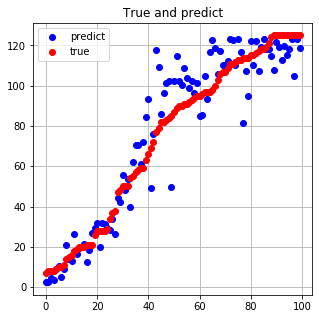

In [26]:
leng = range(100)

#plt.plot(leng, acc, 'r', label='Training accuracy')
#plt.plot(leng, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(5,5))
plt.grid(True) 
plt.plot(leng, holi, 'bo',lw=0.9, label='predict')
plt.plot(leng, list1, 'ro',lw=0.9, label='true')
plt.title('True and predict')
plt.legend()
  

plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(holi, list1))
print(rmse)

12.140436588979243
